# **MÓDULO 33 - Projeto Final de Modelos Avançados**

**Objetivo do Projeto:**

- O objetivo deste projeto é aplicar os conceitos aprendidos nos módulos de conceitos avançados de modelagem para realizar uma segmentação de clientes utilizando o algoritmo de clustering K-Means. Ao final do projeto, você terá a oportunidade de consolidar seus conhecimentos em exploração de dados, pré-processamento, implementação e avaliação de modelos.

**Exploração de Dados:**

- Inicie explorando o dataset fornecido, buscando entender as principais características das variáveis e a distribuição dos dados. Realize análises descritivas, identifique padrões, e verifique a presença de valores ausentes ou inconsistências que precisem ser tratadas.

**Tratamento de Dados:**

- Realize os tratamentos necessários como limpeza de dados, normalização ou padronização das variáveis, e, se necessário, a criação de variáveis derivadas. Documente cada etapa do tratamento, explicando o motivo das escolhas feitas e como elas impactam no modelo.

**Implementação do Algoritmo K-Means:**

- Aplique o algoritmo K-Means no dataset tratado. Defina o número de clusters (k).
- Execute o algoritmo, ajuste os parâmetros conforme necessário, e documente o processo.

**Avaliação e Interpretação dos Resultados:**

- Avalie a qualidade dos clusters gerados utilizando métricas adequadas.
- Interprete os resultados, descrevendo as características de cada cluster e como eles podem ser utilizados para a segmentação de clientes.
- Sugira aplicações práticas para os clusters identificados, como estratégias de marketing direcionadas ou personalização de ofertas.

**O dataset a ser utilizado neste projeto contém informações de 200 clientes, com os seguintes atributos:**

- CustomerID: Identificador único atribuído a cada cliente.
- Gender: Gênero do cliente.
- Age: Idade do cliente.
- Annual Income (k$): Renda anual do cliente em milhares de dólares.
- Spending Score (1-100): Pontuação atribuída pelo shopping com base no comportamento e padrão de gastos do cliente.

*Notem que neste projeto vocês terão autonomia para criar os passos e justificar, sempre, os passos escolhidos.*

# Tratamento inicial dos dados

In [1]:
# BIBLIOTECAS UTILIZADAS

import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
import plotly.express as px
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
from plotly.subplots import make_subplots

In [2]:
# IMPORTANDO O DATASET

df = pd.read_csv("mall_customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# VERIFICANDO TIPOS DE DADOS
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
# VERIFICANDO VALORES NULOS

df.isnull().mean() * 100

CustomerID                0.0
Gender                    0.0
Age                       0.0
Annual Income (k$)        0.0
Spending Score (1-100)    0.0
dtype: float64

In [5]:
# PADRONIZANDO NOMES DAS COLUNAS

df.columns = df.columns.str.upper().str.replace(" ", "_")
df.rename(columns={"ANNUAL_INCOME_(K$)": "ANNUAL_INCOME"}, inplace=True)
df.rename(columns={"SPENDING_SCORE_(1-100)": "SPENDING_SCORE"}, inplace=True)


# ELIMINANDO COLUNA ID
df.drop(columns=["CUSTOMERID"], inplace=True)

# Exploração inicial dos dados

In [6]:
df.describe().round(2)

,AGE,ANNUAL_INCOME,SPENDING_SCORE
count,200.00,200.00,200.00
mean,38.85,60.56,50.20
std,13.97,26.26,25.82
min,18.00,15.00,1.00
25%,28.75,41.50,34.75
50%,36.00,61.50,50.00
75%,49.00,78.00,73.00
max,70.00,137.00,99.00


In [7]:
# GRÁFICO 01: DISTRIBUIÇÃO DAS VARIÁVEIS NUMÉRICAS

fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=(
        'Gráfico A: Idade',
        'Gráfico B: Renda Anual (K$)',
        'Gráfico C: Score de Gastos (1-100)'
    )
)

hist_age = px.histogram(df, x='AGE', nbins=25, histnorm='probability density').data[0]
hist_age.marker.color = 'blue'

hist_income = px.histogram(df, x='ANNUAL_INCOME', nbins=25, histnorm='probability density').data[0]
hist_income.marker.color = 'green'

hist_score = px.histogram(df, x='SPENDING_SCORE', nbins=25, histnorm='probability density').data[0]
hist_score.marker.color = 'red'

fig.add_trace(hist_age, row=1, col=1)
fig.add_trace(hist_income, row=1, col=2)
fig.add_trace(hist_score, row=1, col=3)

fig.update_layout(title_text="Gráfico 01: Distribuição das Variáveis Numéricas")
fig.show()


**ANÁLISE DA DISTRIBUIÇÃO DAS VARIÁVEIS NÚMERICAS**

- **No gráfico A**, podemos notar que nossa base de clientes tem uma concentração maior de pessoas com idade de 20-49 anos. Com destaque a faixa etária de 30-39 que corresponde a 30% do público.
- **No gráfico B**, temos que a maior parte dos nossos clientes possuem uma renda menor que 80.
- **No gráfico C**, podemos ver que aproximadamente 40% da nossa base de clientes possuem um score na faixa de 40-60

In [8]:
# VERIFICANDO ERROS DE DIGITAÇÃO / QUANTIDADE DE MASC E FEM
df['GENDER'].value_counts()

GENDER
Female    112
Male       88
Name: count, dtype: int64

In [9]:
# GRÁFICO 02: SCORE MÉDIO POR GÊNERO

df_grouped = df.groupby('GENDER')['SPENDING_SCORE'].mean().reset_index()

grafico_score_genero = px.bar(
    df_grouped,
    x='GENDER',
    y='SPENDING_SCORE',
    color='GENDER',
    color_discrete_map={
        'Female': 'red',
        'Male': 'blue'
    },
    title='Gráfico 02: Score Médio por Gênero'
)
grafico_score_genero.update_layout(xaxis_title='Gênero', yaxis_title='Score Médio')
grafico_score_genero.show()

In [20]:
# GRÁFICO 03: IDADE VS. SCORE

scatter_idade_score = px.scatter(df, x="AGE", y="SPENDING_SCORE", title="Gráfico 03: Idade vs. Score")
scatter_idade_score.update_layout(xaxis_title='Idade', yaxis_title='Score de Gastos')
scatter_idade_score.show()

In [19]:
# GRÁFICO 04: RENDA ANUAL VS. SCORE

scatter_renda_score = px.scatter(df, x="ANNUAL_INCOME", y="SPENDING_SCORE", title="Gráfico 04: Renda Anual vs. Score")
scatter_renda_score.update_layout(xaxis_title='Renda Anual (K$)', yaxis_title='Score de Gastos')

scatter_renda_score.show()

**ANÁLISE DOS GRÁFICOS**

- **No gráfico 02**, podemos perceber que o score médio entre o público feminino e masculino. Além disso, vale destacar que há uma quantidade de mulheres ligeiramente maior do que a quantidade de homens.
- **No gráfico 03**, podemos indicar a tendência de dois grupos: o primeiro formado por pessoas de 20 a 40 anos com score entre 40-100 e o segundo formado por pessoas acima de 40 anos com score entre 0-60. Os grupos ainda não tem uma forma definida, mas é uma boa indicação para o começo de uma análise.
- **No gráfico 04**, temos grupos mais delimitados. Podemos indicar cinco:
1. RENDA ANUAL: 20-40 / SCORE: 60-100
2. RENDA ANUAL: 20-40 / SCORE: 0-40
3. RENDA ANUAL: 40-60 / SCORE: 40-60
4. RENDA ANUAL: 65-140 / SCORE: 0-40
5. RENDA ANUAL: 65-140 / SCORE: 60-100

**OBSERVAÇÃO**

A fim de complementar da tarefa, aplicarei métodos para definir o número de categorias, como forma de exploração (adicional). 

In [12]:
# ONE HOT ENCODING
gender_mapping = {'Male': 0, 'Female': 1}
df['GENDER'] = df['GENDER'].replace(gender_mapping)

In [13]:
# APLICAÇÃO DO K-MEANS PARA IDADE VS. SCORE - ELBOW METHOD

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['AGE', 'SPENDING_SCORE']])

inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans_idade_score = KMeans(n_clusters=k, 
        n_init=1000,
        random_state=0,
        max_iter=200
        )
    kmeans_idade_score.fit(X_scaled)
    inertias.append(kmeans_idade_score.inertia_)

kl = KneeLocator(
    k_values,
    inertias,
    curve='convex',          
    direction='decreasing'  
)

best_k = kl.elbow
kmeans_idade_score = KMeans(n_clusters=best_k, n_init=1000, random_state=0)
kmeans_idade_score.fit(X_scaled)

centroides_originais = scaler.inverse_transform(kmeans_idade_score.cluster_centers_)
labels = kmeans_idade_score.labels_
df_clusters_idade_score = df.copy()
df_clusters_idade_score['CLUSTER'] = labels.astype(str)

print("O número ideal de clusters é:", best_k)

O número ideal de clusters é: 3


In [14]:
# GRÁFICO 05: IDADE VS. SCORE COM CLUSTERS

scatter_idade_score_cluster = px.scatter(
    df_clusters_idade_score,
    x='AGE',
    y='SPENDING_SCORE',
    color='CLUSTER',
    symbol='CLUSTER',
    title='Gráfico 05: Idade vs. Score com Clusters'
)

scatter_idade_score_cluster.add_scatter(
    x=centroides_originais[:, 0], y=centroides_originais[:, 1],
    mode='markers',
    marker=dict(color='red',
    symbol='x', size=14),
    name='Centroides')


scatter_idade_score_cluster.update_layout(xaxis_title='Idade', yaxis_title='Score de Gastos', legend_title='Cluster')
scatter_idade_score_cluster.show()

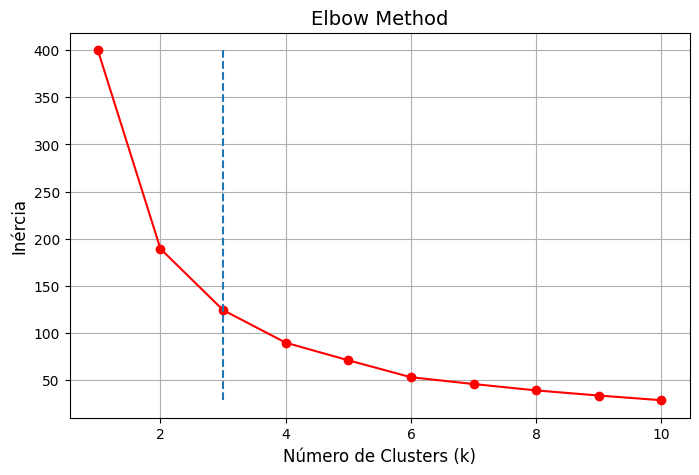

In [15]:
# GRÁFICO ADICIONAL: ELBOW METHOD

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, '-o', color='red')
plt.vlines(kl.elbow, min(inertias), max(inertias), linestyles='dashed')
plt.title('Elbow Method', fontsize=14)
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inércia', fontsize=12)
plt.grid()
plt.show()


**BREVES OBSERVAÇÕES SOBRE O ELBOW METHOD**

**Comentários pessoais**

Particularmente, fiquei em dúvida em relação à avaliação de modelos via métricas e me surgiu a pergunta: como eu posso escolher o número certo de Clusters? Foi quando eu encontrei a referência [2] que me indicou o método utilizado.

**Comentários técnicos**

- **Definição de Inércia:** Soma dos quadrados das distâncias até o centroide do cluster [3];
- **Estratégia para definir o melhor k:** Através da curva do gráfico, escolhemos um pontos onde os retornos decrescentes não compensam mais o custo adicional, ou seja o ponto de curvatura máxima [1]. Como a curva é decrescente e geralmente convexa, podemos buscar um ponto de maior curvatura. Além disso, utilizando a biblioteca `kneed` que estima esse ponto de maior curvatura.

**Referências**

[1] WIKIPEDIA CONTRIBUTORS. Elbow method (clustering). Disponível em: <https://en.wikipedia.org/wiki/Elbow_method_(clustering)>.

[2] MICHILLES, R. Elbow Method e Silhouette Score: como identificar o número ideal de clusters. Disponível em: <https://hub.asimov.academy/blog/elbow-method-e-silhouette-score-numero-cluster/>.

[3] HARRISON, M. Machine Learning – Guia de Referência Rápida. [s.l.] Novatec Editora, 2019.

**Obs.:** Também usei GPT para entender melhor e implementar a biblioteca `kneed`


In [16]:
# APLICAÇÃO DO K-MEANS PARA RENDA VS. SCORE - ELBOW METHOD

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['ANNUAL_INCOME', 'SPENDING_SCORE']])

inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans_renda_score = KMeans(n_clusters=k, 
        n_init=1000,
        random_state=0,
        max_iter=200
        )
    kmeans_renda_score.fit(X_scaled)
    inertias.append(kmeans_renda_score.inertia_)

kl = KneeLocator(
    k_values,
    inertias,
    curve='convex',          
    direction='decreasing'  
)

best_k = kl.elbow
kmeans_renda_score = KMeans(n_clusters=best_k, n_init=1000, random_state=0)
kmeans_renda_score.fit(X_scaled)

centroides_originais = scaler.inverse_transform(kmeans_renda_score.cluster_centers_)
labels = kmeans_renda_score.labels_
df_clusters_renda_score = df.copy()
df_clusters_renda_score['CLUSTER'] = labels.astype(str)


print("O número ideal de clusters é:", best_k)


O número ideal de clusters é: 5


In [17]:
# GRÁFICO 06: RENDA ANUAL VS. SCORE COM CLUSTERS

scatter_renda_score_cluster = px.scatter(
    df_clusters_renda_score,
    x='ANNUAL_INCOME',
    y='SPENDING_SCORE',
    symbol='CLUSTER',
    color='CLUSTER',
    title='Gráfico 06: Renda Anual vs. Score com Clusters'
)

scatter_renda_score_cluster.add_scatter(
    x=centroides_originais[:, 0],
    y=centroides_originais[:, 1],
    mode='markers', 
    marker=dict(color='red', symbol='x', size=14),
    name='Centroides'
)


scatter_renda_score_cluster.update_layout(xaxis_title='Renda Anual', yaxis_title='Score de Gastos', legend_title='Cluster')
scatter_renda_score_cluster.show()

In [18]:
# APLICAÇÃO DO K-MEANS PARA ANÁLISE GERAL - ELBOW METHOD

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['AGE', 'ANNUAL_INCOME', 'SPENDING_SCORE']])


inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans_renda_score = KMeans(n_clusters=k, 
        n_init=1000,
        random_state=0,
        max_iter=200
        )
    kmeans_renda_score.fit(X_scaled)
    inertias.append(kmeans_renda_score.inertia_)

kl = KneeLocator(
    k_values,
    inertias,
    curve='convex',          
    direction='decreasing'  
)

best_k = kl.elbow
kmeans_renda_score = KMeans(n_clusters=best_k, n_init=1000, random_state=0)
kmeans_renda_score.fit(X_scaled)

centroides_originais = scaler.inverse_transform(kmeans_renda_score.cluster_centers_)
labels = kmeans_renda_score.labels_
df_geral = df.copy()
df_geral['CLUSTER'] = labels.astype(str)


print("O número ideal de clusters é:", best_k)


O número ideal de clusters é: 4


**ANÁLISE PÓS-IMPLEMENTAÇÃO DO K-MEANS**

- Temos que a hipótese que fizemos no gráfico 03 provou-se errada no gráfico 05: ao invés de dois grupos, o algoritmo indicou **três**, listados abaixo:
    1. IDADE 20-50 / SCORE 0-40;
    2. IDADE 20-50 / SCORE 40-100;
    3. IDADE 50-70 / SCORE 0-60;

- A hipótese que fizemos em relação ao 04 provou-se correta no gráfico 06, temos a divisão em **cinco** grupos bem delimitados. Em resumo, tivemos aproximadamente os mesmos grupos delimitados na análise inicial.

- Por fim, achei relevante realizar uma análise envolvendo as três variáveis: `AGE`, `ANNUAL_INCOME` e `SPENDING_SCORE` para realizar uma divisão envolvendo uma análise mais geral. Vale destacar que eu não achei relevante fazer uma análise gráfica desse classificação, pois tratou-se de uma projeção 3D que pode confundir a interpretação. Além disso, a variável `GENDER` não foi utilizada por não ser contínua, pelo fato de estarem quase balanceadas, o impacto do não uso é um fator tão prejucial. Por fim, por levar mais de dois fatores, é interessante para traçar melhor o perfil dos clientes.


**ESTRATÉGIAS A SEREM ADOTADAS**

- Acredito que a principal estratégia a ser adotada é uma política de recuperação de score para a terceira idade. Podemos perceber através dos gráficos 02 e 04 que pessoas de IDADE 50-70 possuem SCORE de 0-60. Com esse grupo identificado, é necessário realizar uma análise das possíveis causas que levam a essa faixa etária não aumentar o SCORE e criar políticas para incentivar o aumento deste. 
- A partir dos gráficos 03 e 05, temos dois grupos que se devem ser priorizados para o recebimento de promoções, são eles:
    1. **GRUPO A:** RENDA ANUAL: 40-60 / SCORE: 40-60
    2. **GRUPO B:** RENDA ANUAL: 65-140 / SCORE: 60-100

    Temos que o **GRUPO A** é um público com SCORE e RENDA ANUAL medianos, o que indica que são bons pagadores e possuem uma boa renda. Promoções relacionadas a este padrão de consumo devem ser direcionadas a este grupo. Em relação ao **GRUPO B**, temos que é um grupo de destaque, pois possuem ótimos indíces de consumo e de pagamento, ou seja, são um excelente grupo para direcionar mais promoções e incentivar o consumo.